In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# Read in the data
INPUT_DIR = 'm5-data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

We are given historic sales data in the `sales_train_validation` dataset.
- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

In [ ]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

In [ ]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

In [ ]:
# Merge calendar on our items' data
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

In [ ]:
stv.columns[:6]

In [ ]:
print(f'Number of unique items: {np.unique(stv.item_id).shape[0]}')
print(f'Number of unique department: {np.unique(stv.dept_id).shape[0]}')
print(f'Number of unique categories: {np.unique(stv.cat_id).shape[0]}')
print(f'Number of unique stores: {np.unique(stv.store_id).shape[0]}')
print(f'Number of unique states: {np.unique(stv.state_id).shape[0]}')

In [ ]:
# Transform column wide days to single column 

stv = stv.melt(list(stv.columns[:6]), var_name='day', value_vars=list(stv.columns[6:]), ignore_index=True)

In [ ]:
# Group by the groups to consider (remove product_id as there are 3049 unique) 

stv = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id', 'day']).sum('value').reset_index()

In [ ]:
days_calendar = np.concatenate((stv['day'].unique().reshape(-1,1), cal['date'][:-56].unique().reshape(-1,1)), axis=1)
df_caldays = pd.DataFrame(days_calendar, columns = ['day','Date'])

In [ ]:
# Add calendar days

stv = stv.merge(df_caldays, how='left', on='day')

In [ ]:
stv['Date'] = stv['Date'].astype('datetime64[ns]')
stv.dtypes

In [ ]:
# Transform in weekly data

stv_weekly = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id']).resample('W', on='Date')['value'].sum()

In [ ]:
# Build the structure to then apply the grouping transformation

stv_pivot = stv_weekly.reset_index().pivot(index='Date',columns=['dept_id', 'cat_id', 'store_id', 'state_id'], values='value')
stv_pivot = stv_pivot.fillna(0)

In [ ]:
groups_input = {
    'Department': [0],
    'Category': [1],
    'Store': [2],
    'State': [3]
}

In [6]:
# transform the data to matrix form
g = generate_groups_data_matrix(groups)
dt = data_transform(g)

# if likelihood is normal standardize data
g = dt.std_transf_train()

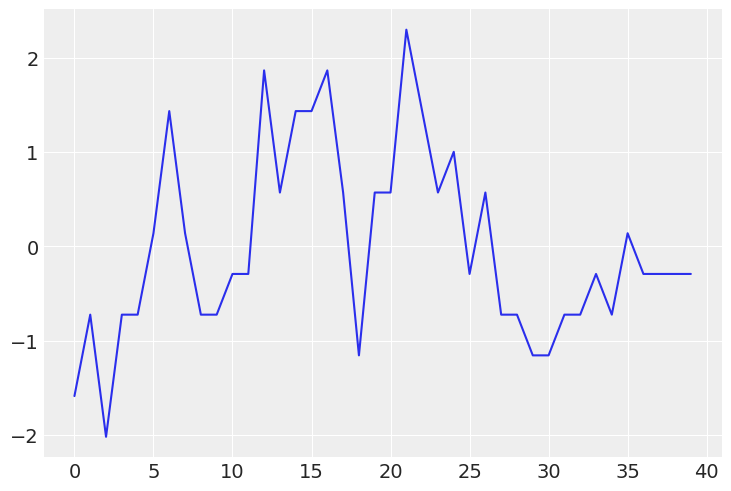

In [7]:
plt.plot(g['train']['data'].T[0]);

In [8]:
g['train']['data'] = g['train']['data'].T

In [9]:
X = np.arange(groups['train']['n']).reshape(-1,1)
X_new = np.arange(groups['predict']['n']).reshape(-1,1)

In [10]:
changepoints = 4
changepoints_t = np.linspace(0, groups['train']['n'], changepoints + 2)[1:-1]
changepoints_t

array([ 8., 16., 24., 32.])

In [11]:
class OutPiecewiseLinearChangepoints():
    # Piecewise linear function applied outside of the GPs and added in the likelihood parameter
    def __init__(self, 
                 k, 
                 m,
                 b,
                 changepoints,
                 groups):
        self.k = k
        self.m = m
        self.b = b
        self.g = groups
        self.changepoints = changepoints

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):
        size_r = X.shape[0]

        X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*X+ (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        
        return piecewise

In [12]:
n_samples = 200
n = groups['predict']['n']
s = groups['predict']['s']

In [ ]:
p_s_fit = []
p_s_predict = []

σ_list = [0.001, 0.01]

for i in range(groups['train']['s']):
        
        for sig in σ_list:
            try:
                with pm.Model() as model:
                    period = pm.Gamma('period', 40, 10)

                    l_t = pm.InverseGamma('l_t', 4, 40)
                    l_p = pm.HalfNormal('l_p', 0.5)
                    η_trend = pm.HalfNormal('η_trend',1)
                    η_per = pm.HalfNormal('η_per',1.5)
                    print(sig)
                    σ  = pm.HalfNormal("σ",  sigma=sig)

                    mu_func = pm.gp.mean.Zero()

                    # cov function for the GP 
                    cov = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
                            + η_per**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p) 
                            + pm.gp.cov.WhiteNoise(σ))

                    gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                    f = gp.prior('f', X=X, reparameterize=True)

                    k = pm.Normal("k", mu=0, sigma=0.01)
                    m = pm.Normal("m", mu=0, sigma=0.01)
                    delta = pm.Normal("delta", mu=0, sigma=0.01, shape=(len(changepoints_t),1))

                    piece = OutPiecewiseLinearChangepoints(k = k,
                                                          m = m,
                                                          b = delta,
                                                          changepoints = changepoints_t,
                                                          groups = g).build(X)
                    piece = piece.reshape((-1,))

                    y_pred = pm.Normal('y_pred', mu=f + piece, observed=g['train']['data'][i])
                    mp = pm.find_MAP(maxeval=10000, progressbar = False)
                break

            except:
                print(f'Error on fitting series {i}')
        
        try:
            with model:
                pred_samples_fit = pm.sample_posterior_predictive([mp], 
                                              vars=[y_pred], 
                                              samples=n_samples,
                                              progressbar=False)

                f_n = gp.conditional('f_n', Xnew=X_new)

                piece = OutPiecewiseLinearChangepoints(k = k,
                                                      m = m,
                                                      b = delta,
                                                      changepoints = changepoints_t,
                                                      groups = g).build(X_new)

                piece = piece.reshape((-1,))

                y_pred_new = pm.Normal("y_pred_new", 
                                        mu=f_n + piece, 
                                        shape=X_new.shape[0])

                pred_samples_predict = pm.sample_posterior_predictive([mp], 
                                                          vars=[y_pred_new], 
                                                          samples=n_samples,
                                                          progressbar = False)

            print('Predicted ' + str(i)+'/'+str(groups['train']['s']-1))
            p_s_fit.append(pred_samples_fit['y_pred'])
            p_s_predict.append(pred_samples_predict['y_pred_new'])
            
        except:
            print(f'Error on predicting series {i}')

0.001


In [ ]:
p_s_fit = np.asarray(p_s_fit)
p_s_predict = np.asarray(p_s_predict)
p_s_fit = p_s_fit.transpose(1, 2, 0)
p_s_predict = p_s_predict.transpose(1, 2, 0)

In [ ]:
g['train']['data'] = g['train']['data'].T

In [ ]:
# Back transform the data and the predictions

p_s_fit_inv = dt.inv_transf_train_general(p_s_fit)
p_s_predict_inv = dt.inv_transf_predict_general(p_s_predict)
g = dt.inv_transf_train()

In [ ]:
visualize_fit(g, p_s_fit_inv, 8)

In [ ]:
visualize_predict(g, p_s_predict_inv, g['h'])

In [ ]:
results = calculate_metrics(p_s_predict_inv, groups)
metrics_to_table( results)